(S-Lab-LASSO)=
# Lab 4: using the LASSO

**Goals**: 
* Learn to use the LASSO to select relevant predictors
* Learn to select a LASSO parameter using cross-validation
* Learn how to use the 1 standard deviation rule

**Useful command**:
* sklearn.linear_model.LassoCV

## Selecting relevant predictors using the LASSO

In this lab, we will examine how the LASSO can be used to select relevant predictors and to construct better linear models. Here, by *better*, we mean models with a better testing error. In order to select an optimal LASSO parameter, we will use cross-validation. Scikit-learn has an object that can perform cross-validation directly for us.

```python
from sklearn.linear_model import LassoCV
```

The file [assay.csv](data/Westbc/assay.csv) contains gene expression data ($p = 7129$ genes) for $n = 49$ breast cancer tumor samples. The file [pheno.csv](data/Westbc/pheno.csv) contains a binary response variable for each sample (whether the sample tested positive or negative for cancer). Our goal is to build a good linear regression model to predict whether a given gene expression profile is likely associated to cancer. 

Let us first try a basic linear regression model.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom

# Load dataset
# pheno = 49 phenotypes
# assay = 7129 x 49 gene expression data

pheno_pd = pd.read_csv('pheno.csv',delimiter=',')
pheno_pd.loc[pheno_pd['nodal.y']=="positive"] = 1
pheno_pd.loc[pheno_pd['nodal.y']=="negative"] = 0

assay_pd = pd.read_csv('assay.csv',delimiter=',')

pheno = np.array(pheno_pd['nodal.y'],dtype=np.double)
assay = np.array(assay_pd)

X = assay.T
y = pheno

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


lin_model = LinearRegression(fit_intercept=True)

# Splitting the data into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Standard linear regression
lin_model.fit(X_train, y_train)
pred = lin_model.predict(X_test)

pred[pred > 0.5] = 1
pred[pred <= 0.5] = 0

perc_correct = (pred == y_test).sum()/np.double(len(y_test))*100

	
print("Percentage of test samples correctly predicted: %1.2f%% \n" % perc_correct)

Percentage of test samples correctly predicted: 53.85% 



Let us now use the LASSO to select relevant genes before fitting the model.

In [3]:
from sklearn.linear_model import LassoCV

# Creating a LASSO cross-validation model with 200 parameters and 10-folds cross-validation.
lasso_model = LassoCV(n_alphas=200, fit_intercept=True, cv=10)  

# Fitting model by cross-validation. This automatically selects a good penalty parameter.
lasso_model.fit(X_train, y_train)

# We pick the parameters that have a nonzero coefficient (we use 1e-6 for numerical precision).
predictors = abs(lasso_model.coef_) > 1e-6

print("Nb. predictors %d\n\n" % predictors.sum())  # Prints the number of predictors selected by the LASSO

if predictors.sum() > 0:
	# Predict using selected variables
	lin_model.fit(X_train[:,predictors],y_train)
	pred = lin_model.predict(X_test[:,predictors]) 
else: 
    print("LASSO selected no predictor.")

pred[pred > 0.5] = 1
pred[pred <= 0.5] = 0

perc_correct_lasso = (pred == y_test).sum()/np.double(len(y_test))*100

print("Percentage of test samples correctly predicted by LASSO: %1.2f%% \n" % perc_correct_lasso)

Nb. predictors 25


Percentage of test samples correctly predicted by LASSO: 69.23% 



In that case, using the LASSO yield a significant increase in precision! 

```{admonition} Exercise

Modify the above codes to use $N = 100$ train/test sets selected at random. Compute the average accuracy of each model and its standard deviation. 
```

```{admonition} Exercise

The <a href="https://archive.ics.uci.edu/datasets" target="_blank">UC Irvine Machine Learning Repository</a> contains a lot of exciting datasets to explore. Look for some datasets with a lot of variables. Using an approach similar to the above, use the LASSO to select good subsets of predictors and verify if that approach yields better prediction results than using a basic linear regression model. 
```

## The one-SD rule

Recall that, when performing cross-validation, we recorded the average error on the different folds for each parameter. Another useful information to record is the standard deviation of the error over the different folds. The following code displays the cross-validation curve along with a one standard derivation band around the error.

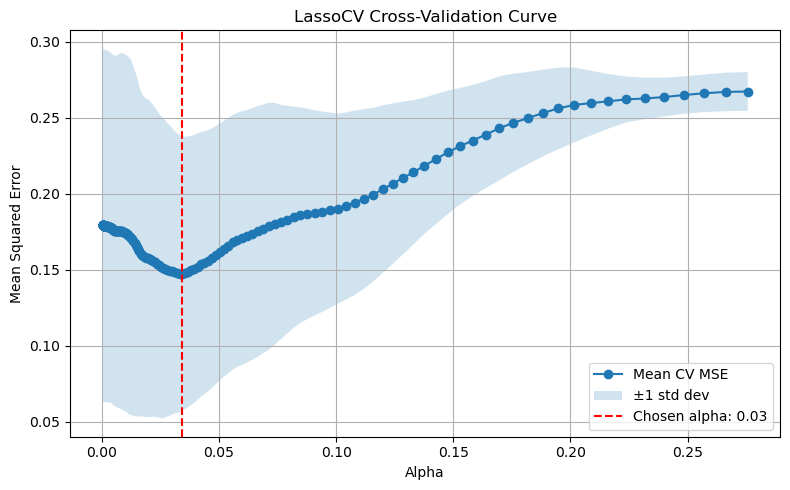

In [9]:
# Plot the CV curve
mean_mse = np.mean(lasso_model.mse_path_, axis=1)
std_mse = np.std(lasso_model.mse_path_, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(lasso_model.alphas_, mean_mse, label='Mean CV MSE', marker='o')
plt.fill_between(lasso_model.alphas_,
                 mean_mse - std_mse,
                 mean_mse + std_mse,
                 alpha=0.2,
                 label='±1 std dev')
plt.axvline(lasso_model.alpha_, color='red', linestyle='--', label=f'Chosen alpha: {lasso_model.alpha_:.2f}')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('LassoCV Cross-Validation Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In some cases, especially when the LASSO selects too many predictors, one may want to work with a larger penalty parameter. For example, in the above figure, one can argue that the error at the penalty parameter $0.12$ is still within a one standard deviation of the minimum error. This can be used to justify using the parameter $0.12$ instead of the selected parameter $0.03$ (the location of the minimum error) in the case where the LASSO solution has a lot of nonzero coefficients. A similar argument can be used to select a smaller parameter when the LASSO solution contains a number of predictors that is too small for one's purposes. 